In [387]:
import os
import ast
import pandas as pd

# 'gao-2018-fhc', 
bin_data_names = ['bretschneider-th-main', 'twitter-hate-speech-tsa', 'bretschneider-th-school', 'gibert-2018-shs', 'us-election-2020', 'cmsb-tsd', 'waseem-and-hovy-2016']
multi_class_data_names = ['founta-2018-thas', 'davidson-thon', 'ami']
data_names = bin_data_names + multi_class_data_names

data_cols = ["data_name", "num_classes", "data_type", "size", "rho", "distribution"]
variant_cols = ['variant', 'sampling_modifiedRS_rho', 'sampling_weightedRS_percentage', 'augmentation_rho', 'augmentation_percentage', 'augmentation_top_k', 'wce_alpha', 'fl_gamma', "augmentation_bert_top_k"]
metric_suffices = ['f1_macro', 'f1_per_label_0', 'f1_per_label_1', 'f1_per_label_2', 'f1_per_label_3', 'f1_per_label_4', 'accuracy', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted', 'auprc']
metrics_cols = [f'train_{suffix}' for suffix in metric_suffices] + [f'val_{suffix}' for suffix in metric_suffices] + [f'test_{suffix}' for suffix in metric_suffices]
cols_raw = data_cols + variant_cols + ['pl_seed'] + metrics_cols + ["best_epoch"] + ['mlflow_run_id']

cols_seeds_mean = data_cols + variant_cols[:-1] + ['val_f1_macro', 'test_f1_macro', 'test_f1_macro_std'] + [f'test_{suffix}' for suffix in metric_suffices[1:]]

results_excel_path = "results_all.xlsx"
cols_results = data_cols + variant_cols[:-1] + ['test_f1_macro', 'test_f1_macro_std']

In [388]:
data2distribution = {}
data2size = {}
data2rho = {}

def read_from_csv(data_name, header=0, names=None):
    if "tsv" in data_name:
        data = pd.read_csv(data_name,
                            sep='\t',
                            encoding = "utf-8",
                            engine = "python",
                            header = header,
                            names = names)
    elif "csv" in data_name:
        data = pd.read_csv(data_name,
                        encoding = "utf-8",
                        engine = "python",
                        header = header,
                        names = names)
    else:
        raise NotImplementedError("Given data file type is not supported yet.")
    return data
def get_data_info_by_data_name(data_name, label_col, category2label, train_filename, val_filename=None, test_filename=None):
    data = read_from_csv(f"./data/{data_name}/{train_filename}")
    label_counts = data[label_col].value_counts()
    if val_filename:
        val_data = read_from_csv(f"./data/{data_name}/{val_filename}")
        label_counts += val_data[label_col].value_counts()
    if test_filename:
        test_data = read_from_csv(f"./data/{data_name}/{test_filename}")
        label_counts += test_data[label_col].value_counts()
    data2size[data_name] = sum(label_counts.values)
    data2distribution[data_name] = {f"{label}_{cat}": round(label_counts[label]/data2size[data_name], 3) for cat, label in category2label.items()}
    data2rho[data_name] = round(max(label_counts.values) / min(label_counts.values), 2)

get_data_info_by_data_name("bretschneider-th-main", "label", {"neutral": 0, "harassment": 1}, "data_clean.csv")
get_data_info_by_data_name("twitter-hate-speech-tsa", "label", {"non-hate": 0, "hate": 1}, "data_clean.csv")
get_data_info_by_data_name("bretschneider-th-school", "label", {"neutral": 0, "harassment": 1}, "data_clean.csv")
get_data_info_by_data_name("gibert-2018-shs", "label", {"no-hate": 0, "hate": 1}, "data_clean.csv")
get_data_info_by_data_name("us-election-2020", "label", {"non-HOF": 0, "HOF": 1}, "train_clean.csv", test_filename="test_clean.csv")
get_data_info_by_data_name("cmsb-tsd", "label", {"non-sexist": 0, "sexist": 1}, "data_clean.csv")
get_data_info_by_data_name("waseem-and-hovy-2016", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
get_data_info_by_data_name("founta-2018-thas", "label_multi", {"normal": 0, "spam": 1, "abusive": 2, "hateful": 3}, "data_clean.csv")
# get_data_info_by_data_name("gao-2018-fhc", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
get_data_info_by_data_name("ami", "label_multi", {"discredit": 0, "stereotype": 1, "dominance": 2, "sexual harassment": 3, "derailing": 4}, "train_clean.csv", test_filename="test_clean.csv")
get_data_info_by_data_name("davidson-thon", "label_multi", {"hate speech": 0, "offensive language": 1, "neither": 2}, "data_clean.csv")

data2distribution, data2size, data2rho

({'bretschneider-th-main': {'0_neutral': 0.936, '1_harassment': 0.064},
  'twitter-hate-speech-tsa': {'0_non-hate': 0.93, '1_hate': 0.07},
  'bretschneider-th-school': {'0_neutral': 0.92, '1_harassment': 0.08},
  'gibert-2018-shs': {'0_no-hate': 0.888, '1_hate': 0.112},
  'us-election-2020': {'0_non-HOF': 0.883, '1_HOF': 0.117},
  'cmsb-tsd': {'0_non-sexist': 0.867, '1_sexist': 0.133},
  'waseem-and-hovy-2016': {'0_neither': 0.735, '1_racism/sexism': 0.265},
  'founta-2018-thas': {'0_normal': 0.717,
   '1_spam': 0.163,
   '2_abusive': 0.085,
   '3_hateful': 0.035},
  'ami': {'0_discredit': 0.514,
   '1_stereotype': 0.142,
   '2_dominance': 0.121,
   '3_sexual harassment': 0.176,
   '4_derailing': 0.046},
  'davidson-thon': {'0_hate speech': 0.058,
   '1_offensive language': 0.774,
   '2_neither': 0.168}},
 {'bretschneider-th-main': 2898,
  'twitter-hate-speech-tsa': 31962,
  'bretschneider-th-school': 1396,
  'gibert-2018-shs': 10703,
  'us-election-2020': 3000,
  'cmsb-tsd': 13631,
  

In [389]:
def get_value_by_run_id(data_dir, run_id, key):
    value = None
    for root, _, files in os.walk(data_dir + run_id):
        if key in files:
            with open(f"{root}/{key}", "r") as f:
                value = f.readlines()[-1]
                if "train" in key or "val" in key or "test" in key:
                    value = value.split()[1]
                if value == "sampling_modifiedRS": # Forgot to specify in the variant value
                    value += "_oversampling"
                if value == "sampling_weightedRS":
                    value += "_combi"
                if "tensor" in value:
                    value = "-"
                try:
                    value = ast.literal_eval(value)
                    if isinstance(value, list):
                        value = [round(v, 2) for v in value]
                        value = tuple(value)
                except (ValueError, SyntaxError):
                    pass
                break
    if value is None:
        value = "-"
        if "train" in key or "val" in key or "test" in key:
            value = 0
    return value

def get_best_epoch_by_run_id(data_dir, run_id):
    ckpt_dir = f"{data_dir}{run_id}/artifacts/model_checkpoints/"
    ckpt = os.listdir(ckpt_dir)[0]
    epoch = ast.literal_eval(ckpt.split("epoch=")[1][1:2])
    return epoch

def get_log_by_data_name(data_name):
    data_runs_dir = f'./logs/{data_name}/'
    run_ids = os.listdir(data_runs_dir)
    rows = []
    for run_id in run_ids:
        run_result = {col_name: get_value_by_run_id(data_runs_dir, run_id, col_name) for col_name in cols_raw[:-2]}
        run_result['best_epoch'] = get_best_epoch_by_run_id(data_runs_dir, run_id)
        run_result['mlflow_run_id'] = run_id
        rows.append(run_result)
    df = pd.DataFrame(columns=cols_raw, data=rows)
    #  - add wfl(alpha=1.0) => fl
    df.loc[(df["variant"] == "wfl") & (df["wce_alpha"] == "-"),  "variant"] = "fl" 
    #  - combine these two columns
    def fix_aug_top_k(row):
        if row["augmentation_top_k"] != "-" or row["augmentation_bert_top_k"] != "-":
            if row["augmentation_top_k"] != "-":
                return row["augmentation_top_k"]
            else:
                return row["augmentation_bert_top_k"]
        else:
            return "-"
    df["augmentation_top_k"] = df.apply(lambda row: fix_aug_top_k(row), axis=1)
    df = df.drop('augmentation_bert_top_k', axis=1)
    return df

def aggregate_results(data_name, writer):
    # Get raw mlflow logs:
    df = get_log_by_data_name(data_name)
    df.to_excel(writer, sheet_name=f"{data_name}_raw")
    assert len(df) % 3 == 0
    # Aggregate results from 3 seeds
    agg_target = {metric: 'mean' for metric in metrics_cols}
    agg_target.update({col: 'first' for col in data_cols})
    df['test_f1_macro_std'] = df.loc[:, 'test_f1_macro']
    agg_target.update({'test_f1_macro_std': 'std'})
    df_seeds_mean = df.groupby(variant_cols[:-1], as_index=False).agg(agg_target)
    #  - change metric to be 00.00
    for metric in metrics_cols + ['test_f1_macro_std']:
        df_seeds_mean[metric] = df_seeds_mean[metric].apply(lambda x: ast.literal_eval("{0:.2f}".format(x*100)))
    
    #  - re-order the columns
    df_seeds_mean.loc[:, "size"] = [data2size[data_name]] * len(df_seeds_mean)
    df_seeds_mean.loc[:, "distribution"] = [data2distribution[data_name]] * len(df_seeds_mean)
    df_seeds_mean.loc[:, "rho"] = [data2rho[data_name]] * len(df_seeds_mean)
    
    df_seeds_mean = df_seeds_mean[cols_seeds_mean]
    df_seeds_mean.to_excel(writer, sheet_name=f"{data_name}_seeds-mean")
    df_val_f1_max = df_seeds_mean.loc[df_seeds_mean.groupby(["variant"])['val_f1_macro'].idxmax()].reset_index(drop=True)
    return df, df_seeds_mean, df_val_f1_max

In [396]:
writer = pd.ExcelWriter(results_excel_path)
df_all_raw_results = pd.DataFrame(columns=cols_raw)
df_all_mean_results = pd.DataFrame(columns=cols_seeds_mean)
df_all_agg_results = pd.DataFrame(columns=cols_results)
for data_name in data_names:
    print(f"Extracting logs for {data_name} ...")
    df, df_seeds_mean, df_val_f1_max = aggregate_results(data_name, writer)
    df_all_raw_results = pd.concat([df_all_raw_results, df], ignore_index=True)
    df_all_mean_results = pd.concat([df_all_mean_results, df_seeds_mean], ignore_index=True)
    df_all_agg_results = pd.concat([df_all_agg_results, df_val_f1_max], ignore_index=True)
df_all_raw_results.to_csv("results/raw_results.csv", index=False)
df_all_mean_results.to_csv("results/mean_results.csv", index=False)
df_all_agg_results = df_all_agg_results.sort_values(by=['data_name', 'test_f1_macro']).reset_index(drop=True)
df_all_agg_results.to_excel(writer, sheet_name=f"best_of_all")

variants = df_all_agg_results.variant.unique()
df_table = pd.DataFrame(columns=data_names)
for variant in variants:
    for data_name in data_names:
        condition = (df_all_agg_results["variant"] == variant) & (df_all_agg_results["data_name"] == data_name)
        if len(df_all_agg_results[condition]) > 0:
            df_table.loc[variant, data_name] = df_all_agg_results[condition]["test_f1_macro"].values[0]
df_table.to_excel(writer, sheet_name=f"Table")
writer.close()

Extracting logs for bretschneider-th-main ...


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/tmp/ipykernel_2664648/573985689.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_raw_results = pd.concat([df_all_raw_results, df], ignore_index=True)
/tmp/ipykernel_2664648/573985689.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavio

Extracting logs for twitter-hate-speech-tsa ...


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Extracting logs for bretschneider-th-school ...


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Extracting logs for gibert-2018-shs ...
Extracting logs for us-election-2020 ...
Extracting logs for cmsb-tsd ...
Extracting logs for waseem-and-hovy-2016 ...
Extracting logs for founta-2018-thas ...
Extracting logs for davidson-thon ...
Extracting logs for ami ...


In [397]:
df_all_agg_results[["data_name", "variant", "test_f1_macro"]]

,data_name,variant,test_f1_macro
0,ami,augmentation_bert,52.11
1,ami,th,53.83
2,ami,sampling_modifiedRS_undersampling,54.46
3,ami,baseline,54.65
4,ami,wfl,55.54
...,...,...,...
91,waseem-and-hovy-2016,th,86.82
92,waseem-and-hovy-2016,wfl,86.82
93,waseem-and-hovy-2016,augmentation_bert,86.99
94,waseem-and-hovy-2016,sampling_modifiedRS_oversampling,87.16


In [398]:
df_table

,bretschneider-th-main,twitter-hate-speech-tsa,bretschneider-th-school,gibert-2018-shs,us-election-2020,cmsb-tsd,waseem-and-hovy-2016,founta-2018-thas,davidson-thon,ami
augmentation_bert,70.57,87.49,73.75,75.74,73.46,84.85,86.99,63.37,75.95,52.11
th,70.6,86.18,74.11,77.11,77.06,84.91,86.82,61.9,74.33,53.83
sampling_modifiedRS_undersampling,72.81,NaN,75.09,75.72,74.65,84.76,NaN,64.38,76.57,54.46
baseline,68.89,87.21,69.82,76.89,75.62,84.36,86.72,62.7,74.7,54.65
wfl,71.83,87.36,73.02,76.39,74.73,84.84,86.82,64.22,75.52,55.54
sampling_modifiedRS_oversampling,73.72,87.65,76.23,77.25,73.49,84.83,87.16,63.98,75.48,55.7
fl,69.11,NaN,71.08,77.45,74.44,84.72,86.62,63.55,74.74,56.44
augmentation_external_data,61.65,84.18,61.57,74.23,75.05,81.48,86.31,60.83,73.01,NaN
sampling_weightedRS_oversampling,70.68,NaN,73.95,NaN,76.51,NaN,87.46,NaN,74.77,NaN
sampling_weightedRS_combi,71.46,NaN,74.65,NaN,73.39,NaN,86.35,62.46,74.66,NaN


## Plot results

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sns.set_context("paper")

In [205]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [328]:
data_name_orig2display = {'bretschneider-th-main': 'Bretschneider-Main', 
                            'twitter-hate-speech-tsa': 'Twitter-Hate-Speech', 
                            'bretschneider-th-school': 'Bretschneider-School', 
                            'gibert-2018-shs': 'Gibert-2018', 
                            'us-election-2020': 'US-Election-2020', 
                            'cmsb-tsd': 'CMSB', 
                            'waseem-and-hovy-2016': 'Waseem-and-Hovy-2016',
                            'founta-2018-thas': 'Founta-2018', 
                            'davidson-thon': 'Davidson-2017', 
                            'ami': 'AMI'}

### Random Oversampling: Overfitting

In [215]:
df_overfitting = df_all_raw_results[df_all_raw_results["variant"].isin(["baseline", "sampling_modifiedRS_oversampling"])][["data_name", "sampling_modifiedRS_rho", "train_f1_macro", "val_f1_macro", "test_f1_macro", "pl_seed"]]
df_overfitting = df_overfitting.groupby(["data_name", "sampling_modifiedRS_rho"], as_index=False).agg({"data_name": "first", "train_f1_macro": "mean", "val_f1_macro": "mean", "test_f1_macro": "mean"})

def compute_deviation_to_baseline(row, split):
    baseline_condition = (df_overfitting["data_name"] == row["data_name"]) & (df_overfitting["sampling_modifiedRS_rho"] == "-")
    baseline_value = df_overfitting.loc[baseline_condition, f"{split}_f1_macro"].values[0]
    return row[f"{split}_f1_macro"] - baseline_value
for split in ["train", "val", "test"]:
    df_overfitting[f"{split}_f1_macro_delta"] = df_overfitting.apply(lambda row: compute_deviation_to_baseline(row, split), axis=1)
    df_overfitting[f"{split}_f1_macro_delta"] = df_overfitting[f"{split}_f1_macro_delta"].apply(lambda x: ast.literal_eval("{0:.2f}".format(x*100)))
df_overfitting = df_overfitting[df_overfitting["sampling_modifiedRS_rho"] != "-"]
df_overfitting = df_overfitting[df_overfitting["data_name"].isin(["founta-2018-thas", "davidson-thon", "cmsb-tsd"])]
df_overfitting = df_overfitting[["sampling_modifiedRS_rho", "data_name", "train_f1_macro_delta", "val_f1_macro_delta", "test_f1_macro_delta"]]
df_overfitting

,sampling_modifiedRS_rho,data_name,train_f1_macro_delta,val_f1_macro_delta,test_f1_macro_delta
25,1.0,cmsb-tsd,1.01,-0.54,0.54
26,1.2,cmsb-tsd,1.10,0.06,0.56
27,1.5,cmsb-tsd,0.95,0.03,1.03
28,2.0,cmsb-tsd,1.12,-0.04,0.12
29,3.0,cmsb-tsd,0.54,0.22,1.09
30,5.0,cmsb-tsd,0.44,0.31,0.47
32,1.0,davidson-thon,5.91,0.82,0.72
33,1.2,davidson-thon,5.91,0.59,-0.46
34,1.5,davidson-thon,5.69,2.01,0.78
35,2.0,davidson-thon,5.74,1.46,-0.19


In [216]:
df_overfitting_expanded = pd.DataFrame(columns=["sampling_modifiedRS_rho", "data_name", "split", "f1_delta"])
rhos_unique = df_overfitting.sampling_modifiedRS_rho.unique().tolist()
data_names_unique = df_overfitting.data_name.unique().tolist()
data_names_list = []
for data_name in data_names_unique:
    data_names_list += [data_name_orig2display[data_name]] * 3 * len(rhos_unique)
df_overfitting_expanded["data_name"] = data_names_list
rhos_list = []
for rho in rhos_unique:
    rhos_list += [rho] * 3
df_overfitting_expanded["sampling_modifiedRS_rho"] = rhos_list * len(data_names_unique)
splits = ["train", "val", "test"]
df_overfitting_expanded["split"] = splits * len(rhos_unique) * len(data_names_unique)
for data_name in data_names_unique:
    for split in splits:
        for rho in rhos_unique:
            where_to_assign = ((df_overfitting_expanded["data_name"] == data_name_orig2display[data_name]) 
                                & (df_overfitting_expanded["split"] == split)
                                & (df_overfitting_expanded["sampling_modifiedRS_rho"] == rho))
            value_from_where = ((df_overfitting["data_name"] == data_name)
                                & (df_overfitting["sampling_modifiedRS_rho"] == rho))
            if len(df_overfitting[value_from_where]) > 0:
                value = df_overfitting.loc[value_from_where, f"{split}_f1_macro_delta"].values[0]
                df_overfitting_expanded.loc[where_to_assign, "f1_delta"] = value
df_overfitting_expanded

,sampling_modifiedRS_rho,data_name,split,f1_delta
0,1.0,CMSB,train,1.01
1,1.0,CMSB,val,-0.54
2,1.0,CMSB,test,0.54
3,1.2,CMSB,train,1.1
4,1.2,CMSB,val,0.06
...,...,...,...,...
76,10.0,Founta-2018,val,0.76
77,10.0,Founta-2018,test,1.28
78,15.0,Founta-2018,train,-1.73
79,15.0,Founta-2018,val,0.05


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


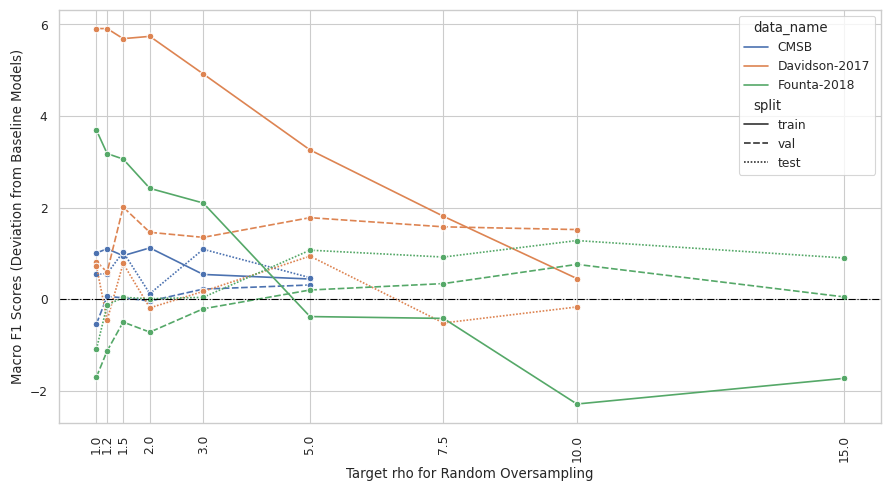

In [305]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,5))
sns.lineplot(x="sampling_modifiedRS_rho", y="f1_delta", data=df_overfitting_expanded, 
                hue="data_name", style="split", marker="o", ax=ax)#
rho_ticks = rhos_unique
ax.set_xticks(rho_ticks, labels=rho_ticks, rotation=90)
ax.set_xlabel("Target rho for Random Oversampling")
# delta_ticks = [y for y in list(range(-2, 8, 2))]
# ax.set_yticks(delta_ticks)
ax.set_ylabel("Macro F1 Scores (Deviation from Baseline Models)")
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
ax.figure.tight_layout()
ax.figure.savefig('output_figure.svg', dpi=600, bbox_inches="tight")

### Weighted Cross Entropy

In [339]:
conditions = (df_all_mean_results["variant"] == "wce") & (df_all_mean_results["num_classes"] == 2)
df_mean_wce = df_all_mean_results[conditions][["data_name", "wce_alpha", "test_f1_per_label_1"]]
def compute_deviation_to_baseline(row):
    baseline_condition = (df_all_mean_results["data_name"] == row["data_name"]) & (df_all_mean_results["variant"] == "baseline")
    baseline_value = df_all_mean_results.loc[baseline_condition, "test_f1_per_label_1"].values[0]
    return row['test_f1_per_label_1'] - baseline_value
df_mean_wce["pos_f1_delta"] = df_mean_wce.apply(lambda row: compute_deviation_to_baseline(row), axis=1)
df_mean_wce["data_name"] = df_mean_wce["data_name"].map(data_name_orig2display)
df_mean_wce = df_mean_wce[df_mean_wce["fl_gamma"] >= 0.25]
df_mean_wce

,data_name,wce_alpha,test_f1_per_label_1,pos_f1_delta
41,Bretschneider-Main,0.25,13.70,-28.33
42,Bretschneider-Main,0.75,43.34,1.31
43,Bretschneider-Main,0.9,46.10,4.07
44,Bretschneider-Main,0.936,48.03,6.00
45,Bretschneider-Main,0.95,47.85,5.82
46,Bretschneider-Main,0.99,43.46,1.43
191,Bretschneider-School,0.25,12.58,-32.65
192,Bretschneider-School,0.75,55.22,9.99
193,Bretschneider-School,0.9,54.77,9.54
194,Bretschneider-School,0.92,57.95,12.72


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


bretschneider-th-main 0.936 6.0
bretschneider-th-school 0.92 12.720000000000006
us-election-2020 0.875 -0.269999999999996
waseem-and-hovy-2016 0.735 0.1799999999999926


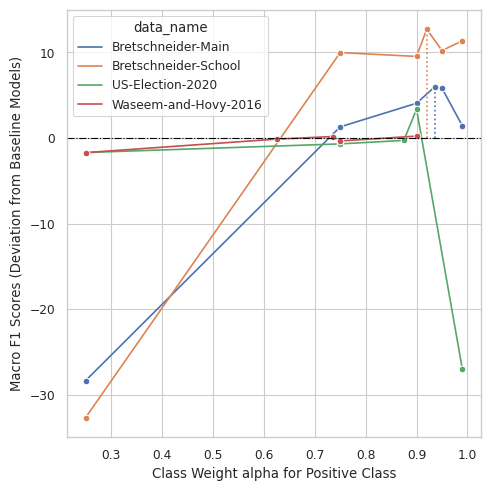

In [343]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(x="wce_alpha", y="pos_f1_delta", data=df_mean_wce, hue="data_name", marker="o", ax=ax)

data2alpha = {"bretschneider-th-main": 0.936, "bretschneider-th-school": 0.92, "us-election-2020": 0.875, "waseem-and-hovy-2016": 0.735}
for i, (data_name, alpha) in enumerate(data2alpha.items()):
    where_is_alpha = (df_mean_wce["data_name"] == data_name_orig2display[data_name]) & (df_mean_wce["wce_alpha"] == alpha)
    delta = df_mean_wce.loc[where_is_alpha, "pos_f1_delta"].values[0]
    print(data_name, alpha, delta)
    ymin = min(0, delta)
    ymax = max(0, delta)
    ax.plot((data2alpha[data_name], data2alpha[data_name]), (ymin, ymax), color=sns.color_palette()[i], ls=":")
# rho_ticks = rhos_unique
# ax.set_xticks(rho_ticks, labels=rho_ticks, rotation=90)
ax.set_xlabel("Class Weight alpha for Positive Class")
# # delta_ticks = [y for y in list(range(-2, 8, 2))]
# # ax.set_yticks(delta_ticks)
ax.set_ylabel("Macro F1 Scores (Deviation from Baseline Models)")
# # '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
ax.figure.tight_layout()
ax.figure.savefig('output_figure.svg', dpi=600, bbox_inches="tight")

In [356]:
conditions = (df_all_mean_results["variant"] == "wce") & (df_all_mean_results["num_classes"] > 2)
df_mean_wce_multi = df_all_mean_results[conditions][["data_name", "wce_alpha", "test_f1_macro"]]
df_mean_wce_multi["data_name"] = df_mean_wce_multi["data_name"].map(data_name_orig2display)
df_mean_wce_multi

,data_name,wce_alpha,test_f1_macro


### Focal Loss

In [354]:
conditions = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["num_classes"] == 2)
df_mean_fl = df_all_mean_results[conditions][["data_name", "fl_gamma", "test_f1_per_label_1"]]
def compute_deviation_to_baseline(row):
    baseline_condition = (df_all_mean_results["data_name"] == row["data_name"]) & (df_all_mean_results["variant"] == "baseline")
    baseline_value = df_all_mean_results.loc[baseline_condition, "test_f1_per_label_1"].values[0]
    return row['test_f1_per_label_1'] - baseline_value
df_mean_fl["pos_f1_delta"] = df_mean_fl.apply(lambda row: compute_deviation_to_baseline(row), axis=1)
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)
df_mean_fl

,data_name,fl_gamma,test_f1_per_label_1,pos_f1_delta
9,Bretschneider-Main,0.1,36.42,-5.61
10,Bretschneider-Main,0.2,44.70,2.67
11,Bretschneider-Main,0.5,43.43,1.40
12,Bretschneider-Main,1.0,42.55,0.52
13,Bretschneider-Main,2.0,40.69,-1.34
14,Bretschneider-Main,5.0,41.98,-0.05
161,Bretschneider-School,0.1,47.77,2.54
162,Bretschneider-School,0.2,39.11,-6.12
163,Bretschneider-School,0.5,53.21,7.98
164,Bretschneider-School,1.0,48.11,2.88


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


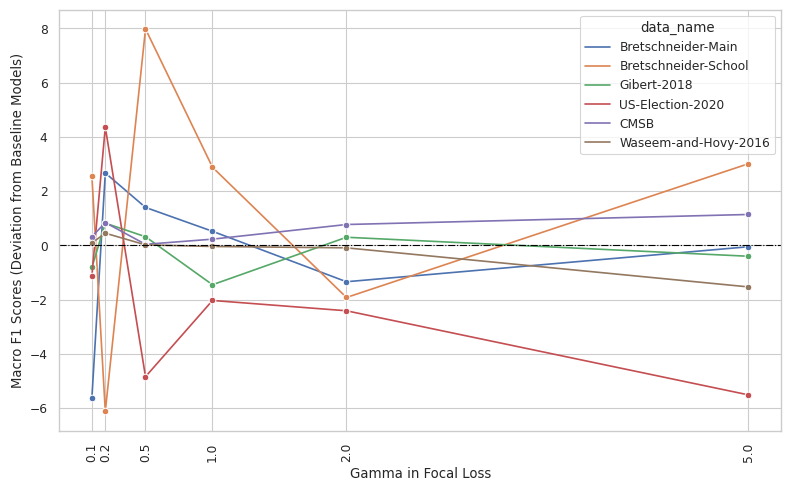

In [355]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(x="fl_gamma", y="pos_f1_delta", data=df_mean_fl, hue="data_name", marker="o", ax=ax)
gamma_ticks = df_mean_fl.fl_gamma.unique().tolist()
ax.set_xticks(gamma_ticks, labels=gamma_ticks, rotation=90)
ax.set_xlabel("Gamma in Focal Loss")
# # delta_ticks = [y for y in list(range(-2, 8, 2))]
# # ax.set_yticks(delta_ticks)
ax.set_ylabel("Macro F1 Scores (Deviation from Baseline Models)")
# # '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
ax.figure.tight_layout()
ax.figure.savefig('output_figure.svg', dpi=600, bbox_inches="tight")

### Weighted Focal Loss

In [360]:
conditions = (df_all_mean_results["variant"] == "wfl")
df_mean_wfl = df_all_mean_results[conditions][["data_name", "wce_alpha", "fl_gamma", "test_f1_macro"]]
df_mean_wfl["data_name"] = df_mean_wfl["data_name"].map(data_name_orig2display)
df_mean_wfl

,data_name,wce_alpha,fl_gamma,test_f1_macro
47,Bretschneider-Main,0.1,0.1,48.35
48,Bretschneider-Main,0.1,0.2,48.35
49,Bretschneider-Main,0.1,0.5,48.35
50,Bretschneider-Main,0.1,1.0,48.35
51,Bretschneider-Main,0.1,2.0,48.35
...,...,...,...,...
531,Waseem-and-Hovy-2016,0.9,0.2,85.80
532,Waseem-and-Hovy-2016,0.9,0.5,86.15
533,Waseem-and-Hovy-2016,0.9,1.0,86.71
534,Waseem-and-Hovy-2016,0.9,2.0,86.76


## Check MLflow runs

In [393]:
mlrun_ids = []

with open("./outputs/bretschenider-th-main/bretschneider-th-main_augmentation_external_data_seed0_output.txt", "r") as f:
    log_contents = f.readlines()
    mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

with open("./outputs/bretschenider-th-main/bretschneider-th-main_augmentation_external_data_seed21_output.txt", "r") as f:
    log_contents = f.readlines()
    mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

with open("./outputs/bretschenider-th-main/bretschneider-th-main_augmentation_external_data_seed42_output.txt", "r") as f:
    log_contents = f.readlines()
    mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]
    
# with open("./outputs/ami/ami_augmentation_bert_seed0_output.txt", "r") as f:
#     log_contents = f.readlines()
#     mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

for id in mlrun_ids:
    print(id)

len(mlrun_ids)

907b26b58535445f9f784d9ebcab97f8
1081891cd6b84d7b86a2c27914aee63e
87ad3a14a16845768b6b8f282c80bf29
457463acc3f4412290a7731f8cf2662c
190ece52c8ea470391b60e00a90c5ae1
07ed33057ca341828b8fa640cc56de38
3f05456aee2a442a8ef13018c289d9db
024a86a1f48842f187255b862d34d984
0b25a87de2434001b46b3811c800af4d


9

In [395]:
import os
data_runs_dir = f'./logs/bretschneider-th-main/'
run_ids = os.listdir(data_runs_dir)
logs = dict()
for run_id in run_ids:
    ckpt_dir = f"{data_runs_dir}{run_id}/artifacts/model_checkpoints/"
    try:
        ckpt = os.listdir(ckpt_dir)[0]
        if "external" in ckpt:
            # print(f"{run_id}\t{ckpt}")
            # for root, _, files in os.walk(data_runs_dir + run_id):
            #     key = "augmentation_rho"
            #     if key in files:
            #         with open(f"{root}/{key}", "r") as f:
            #             value = f.readlines()[-1]
            #             print(f"{key}={value}")
            #     key = "augmentation_percentage"
            #     if key in files:
            #         with open(f"{root}/{key}", "r") as f:
            #             value = f.readlines()[-1]
            #             print(f"{key}={value}")
            #     key = "augmentation_top_k"
            #     if key in files:
            #         with open(f"{root}/{key}", "r") as f:
            #             value = f.readlines()[-1]
            #             print(f"{key}={value}")
            #     key = "augmentation_bert_top_k"
            #     if key in files:
            #         with open(f"{root}/{key}", "r") as f:
            #             value = f.readlines()[-1]
            #             print(f"{key}={value}")
            print(f"{run_id}\t{ckpt}")
            logs[run_id] = ckpt
    except NotADirectoryError:
        pass
len(logs)

07ed33057ca341828b8fa640cc56de38	bretschneider-th-main-augmentation_external_data-Trial_2augmentation_rho=1.5augmentation_categories=['hate']-seed21-epoch=03-val_f1_macro=0.69.ckpt
1081891cd6b84d7b86a2c27914aee63e	bretschneider-th-main-augmentation_external_data-Trial_1augmentation_rho=1.5augmentation_categories=['hate']-seed0-epoch=05-val_f1_macro=0.72.ckpt
190ece52c8ea470391b60e00a90c5ae1	bretschneider-th-main-augmentation_external_data-Trial_1augmentation_rho=1.2augmentation_categories=['hate']-seed21-epoch=00-val_f1_macro=0.71.ckpt
3f05456aee2a442a8ef13018c289d9db	bretschneider-th-main-augmentation_external_data-Trial_0augmentation_rho=1.5augmentation_categories=['hate']-seed42-epoch=00-val_f1_macro=0.69.ckpt
457463acc3f4412290a7731f8cf2662c	bretschneider-th-main-augmentation_external_data-Trial_0augmentation_rho=1.0augmentation_categories=['hate']-seed21-epoch=03-val_f1_macro=0.71.ckpt
0b25a87de2434001b46b3811c800af4d	bretschneider-th-main-augmentation_external_data-Trial_2augment

9

In [39]:
("a", 1) in [("a", 1), ("b", 2)]

True

In [28]:
import ast
ckpt = "davidson-thon-augmentation_bert-Trial_6augmentation_percentage=0.3augmentation_top_k=3-seed42-epoch=00-val_f1_macro=0.72.ckpt"
ast.literal_eval(ckpt.split("epoch=")[1][:2])

0